In [1]:
%load_ext autoreload
%autoreload 2 

In [2]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from utils import (
    auprc,
    factor_enrichment_gsea,
    get_gprofiler,
    perturbation_signal_recovery,
    read_aws_csv,
    read_aws_h5ad,
    read_aws_pickle,
    retrieve_stringdb_neighbors,
    split_data_by_cell,
)

In [3]:
# read in trained model outputs generated from ./PertSpectra_load_checkpoints/pertspectra_replogle.ipynb
adata = read_aws_h5ad(
    "s3://pert-spectra/PertSpectra_checkpoints/pertspectra_replogle/replogle.h5ad"
)

# Reconstruction

## Spearman Coefficient
- Spearman correlation between predicted and observed expression (on DE genes if available)

In [5]:
from scipy.stats import spearmanr

test_corr_singles = []
test_corr_combos = []
train_idx, val_idx, test_idx = split_data_by_cell(
    adata.X, adata.obs["gene"], test_size=0.2, val_size=0.2
)
adata_test = adata[test_idx]

for pert in adata_test.obs["gene"].unique():
    hold_idx = [i for i, x in enumerate(adata_test.obs["gene"]) if x == pert]
    recon = adata.uns["recon"][hold_idx]
    # correlation
    mean_reconstruction = recon.mean(axis=0)
    mean_observed = np.squeeze(np.array(adata_test[hold_idx].X.mean(axis=0)))
    if ("+" in pert) and ("ctrl" not in pert):
        test_corr_combos.append(
            [pert, spearmanr(mean_reconstruction, mean_observed)[0]]
        )
    else:
        test_corr_singles.append(
            [pert, spearmanr(mean_reconstruction, mean_observed)[0]]
        )

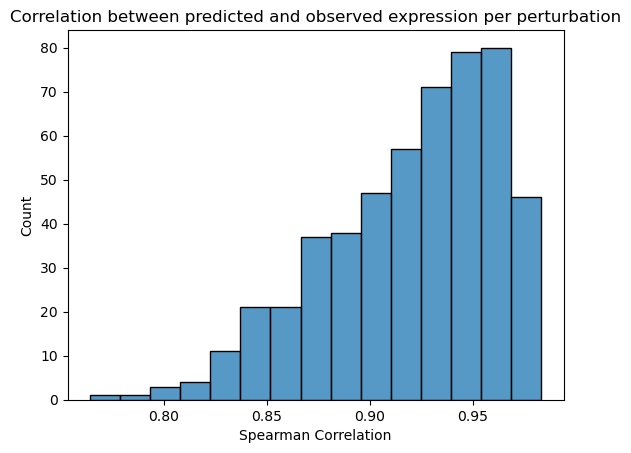

In [6]:
# plot train correlation distribution vs test correlation distribution
test_corr = np.array(test_corr_singles + test_corr_combos)[:, 1].astype(float)
sns.histplot(test_corr, label="test_corr")
plt.title("Correlation between predicted and observed expression per perturbation")
plt.xlabel("Spearman Correlation")
plt.show()

In [7]:
np.savetxt(
    "figures/reconstruction_spearmans/model_replogle_spearman_correlations.csv",
    test_corr,
    delimiter=",",
    fmt="%.2f",
)

# Perturbation Embedding Heatmap

## Hierarchical Clustering + Enrichment
- Perform enrichment tests (gprofiler) on hierarchical clustering of perturbation embeddings

In [ ]:
import seaborn as sns
from scipy.spatial.distance import pdist, squareform

# Compute the pairwise distances
pert_embeddings_df = pd.DataFrame(
    adata.uns["SPECTRA_pert_scores"], index=adata.uns["Spectra_pert_labels"]
)
df = pert_embeddings_df.drop(index=["basal", "ctrl"])

distance = "euclidean"
distances = pdist(df.values, metric=distance)

# Convert the distances into a square distance matrix
distance_matrix = pd.DataFrame(squareform(distances), index=df.index, columns=df.index)
clustermap = sns.clustermap(distance_matrix, cmap="viridis_r")
clustermap.fig.suptitle(f"Pairwise {distance} distance of perturbation latent vectors")
# clustermap.ax_row_dendrogram.set_visible(False)
clustermap.ax_col_dendrogram.set_visible(False)
plt.show()

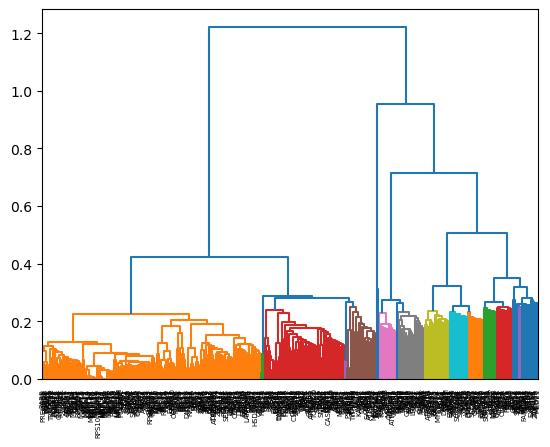

In [8]:
import scipy

den = scipy.cluster.hierarchy.dendrogram(
    clustermap.dendrogram_col.linkage,
    labels=distance_matrix.index,
    color_threshold=0.25,
)

In [9]:
# extract clusters and perform gprofiler
from collections import defaultdict


def get_cluster_classes(den, label="ivl"):
    cluster_idxs = defaultdict(list)
    for c, pi in zip(den["color_list"], den["icoord"]):
        for leg in pi[1:3]:
            i = (leg - 5.0) / 10.0
            if abs(i - int(i)) < 1e-5:
                cluster_idxs[c].append(int(i))
    cluster_classes = {}
    for c, l in cluster_idxs.items():  # noqa
        i_l = [den[label][i] for i in l]
        cluster_classes[c] = i_l
    return cluster_classes


clusters = get_cluster_classes(den)
# extract functions for clusters
cluster_process = {}
for c in clusters:
    cluster_df = pd.DataFrame(clusters[c], columns=["gene_symbol"])
    res = get_gprofiler(cluster_df)
    cluster_process[c] = res[res["p_value"] <= 0.05]

In [15]:
# save grpofiler results
with open(
    "figures/pert_embedding_cluster_gprofiler/pertspectra_replogle_pert_emb_gprofiler.pickle",
    "wb",
) as handle:
    pickle.dump(cluster_process, handle, protocol=pickle.HIGHEST_PROTOCOL)

## PR Curve+AUC
- AUCPR using prior graph as binary label

In [16]:
aucpr_df, f1_df, pr_dict = auprc(distance_matrix)
print(aucpr_df)
print(f1_df)
aucpr_df.to_csv("figures/pert_embedding_recall/pertspectra_replogle_aucpr.csv")
f1_df.to_csv("figures/pert_embedding_recall/pertspectra_replogle_f1.csv")

               AUC
StringDB  0.215162
CORUM     0.262926
                F1  Threshold
StringDB  0.246123   0.869706
CORUM     0.306326   0.884541


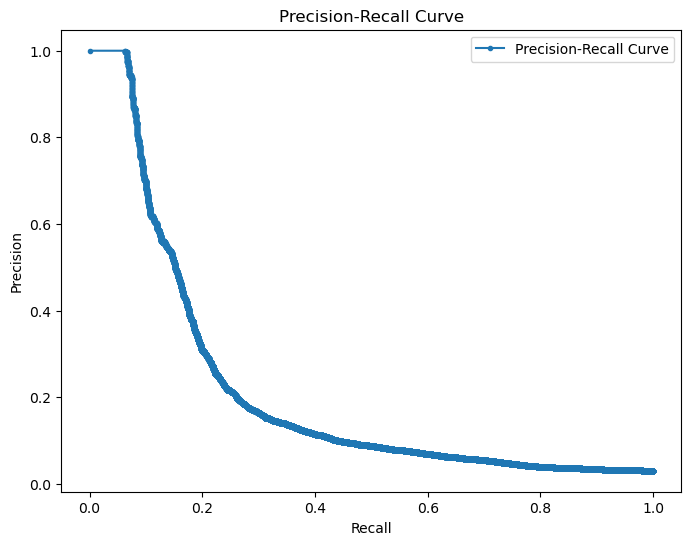

In [17]:
# Plot the precision-recall curve
prior = "StringDB"
plt.figure(figsize=(8, 6))
plt.plot(
    pr_dict[prior]["recall"],
    pr_dict[prior]["precision"],
    marker=".",
    label="Precision-Recall Curve",
)
# Adding labels and title
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
# Save the plot
plt.show()

# Interpretability of our learned latent space

## Factor Enrichment
- GSEA on log transformed latent-by-gene factors
- Then associate each perturbation to its top latent factors

In [ ]:
factor_to_go = factor_enrichment_gsea(adata, adata.uns["SPECTRA_factors"], fdr=5e-2)

In [ ]:
# filter and add description to processes
go_df = read_aws_csv("s3://pert-spectra/references/GO_to_Description.txt")
go_df.set_index("Term", inplace=True)
go_dict = go_df.to_dict()["Description"]

filtered_factor_to_go = {}
for i in factor_to_go:
    proc = factor_to_go[i]
    proc["descr"] = [go_dict[x] for x in proc["GO_ID"]]
    filtered_factor_to_go[i] = proc

In [ ]:
filtered_factor_to_go

In [ ]:
with open(
    "figures/factor_enrichments/MODEL_replogle_factor_enrichment.pickle", "wb"
) as handle:
    pickle.dump(filtered_factor_to_go, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Overlap with prior knowledge/ground truth
- Group A: a set of GO terms associated with a perturbation (either drivers from msigdb, or from literature) and its neighbors in stringdb
- Group B: a set of GO terms from the interpretability analysis
- Hypergeometric test on the overlap of the two groups

In [11]:
# load precomputed factor_to_go dict if available
filtered_factor_to_go = read_aws_pickle(
    "s3://pert-spectra/figures/factor_enrichments/pertspectra_replogle_factor_enrichment.pickle"
)

In [12]:
# get neighbors for each perturbation
pert_neighbors = retrieve_stringdb_neighbors(adata.uns["Spectra_pert_labels"])

In [13]:
# construct group A - known processes for each perturbation
gene_sets = read_aws_pickle("s3://pert-spectra/references/GO_to_Gene.pickle")
# BP only go terms
go_reference = read_aws_csv("s3://pert-spectra/references/GO_terms.txt.gz", zipped=True)
go_bp = go_reference[go_reference["go_category"] == "biological_process"]
go_bp_ids = set(go_bp["go_id"].values)
filtered_go_terms = {key: gene_sets[key] for key in go_bp_ids if key in gene_sets}

# GO terms per perturbation AND its neighbors in stringdb
pert_to_go = {key: set() for key in adata.uns["Spectra_pert_labels"]}
for goterm in filtered_go_terms:
    for pert in adata.uns["Spectra_pert_labels"]:
        if pert in filtered_go_terms[goterm] and set(
            filtered_go_terms[goterm]
        ).intersection(pert_neighbors[pert]):
            pert_to_go[pert].add(goterm)

In [14]:
# construct set B - model identified processes for each perturbation
n = 10  # number of top factors to get processes from
model_pert_to_go = {}
for pert in adata.uns["Spectra_pert_labels"]:
    if pert in ["ctrl", "intergenic", "basal"]:
        continue
    # get top factors
    pert_embeddings_df = pd.DataFrame(
        adata.uns["SPECTRA_pert_scores"], index=adata.uns["Spectra_pert_labels"]
    )
    pert_loading = pert_embeddings_df.loc[pert]
    ctrl_loading = pert_embeddings_df.loc["ctrl"]
    delta_loading = np.abs(np.log(pert_loading) - np.log(ctrl_loading))
    top_n_factors = np.argpartition(np.array(delta_loading), -n)[-n:]
    # get processes
    model_processes = set()
    for f in top_n_factors:
        proc = filtered_factor_to_go[f]
        model_processes = model_processes.union(set(proc["Term"]))
    model_pert_to_go[pert] = model_processes

In [15]:
pvals = perturbation_signal_recovery(
    pert_to_go,
    model_pert_to_go,
    list(filtered_go_terms.keys()),
    list(adata.uns["Spectra_pert_labels"]),
)

Overlap for ATP6AP1: 0 out of 9 in researchDB
P-value for ATP6AP1: 1.0
Overlap for RPL30: 0 out of 5 in researchDB
P-value for RPL30: 1.0
Overlap for DDX21: 3 out of 13 in researchDB
P-value for DDX21: 5.980456287677466e-05
Overlap for PHB: 2 out of 24 in researchDB
P-value for PHB: 0.010741839670463106
Overlap for DMAP1: 1 out of 14 in researchDB
P-value for DMAP1: 0.06354093376899977
Overlap for MCRS1: 1 out of 19 in researchDB
P-value for MCRS1: 0.10580925901854948
Overlap for CCNH: 3 out of 7 in researchDB
P-value for CCNH: 3.0005424766078534e-05
Overlap for NUMA1: 1 out of 6 in researchDB
P-value for NUMA1: 0.03329641937620341
Overlap for ALDOA: 0 out of 6 in researchDB
P-value for ALDOA: 1.0
Overlap for SNAPC3: 0 out of 5 in researchDB
P-value for SNAPC3: 1.0
Overlap for SEC61A1: 0 out of 8 in researchDB
P-value for SEC61A1: 1.0
Overlap for CCT3: 3 out of 10 in researchDB
P-value for CCT3: 5.402090913326375e-05
Overlap for EIF6: 2 out of 6 in researchDB
P-value for EIF6: 0.000615

In [31]:
# save as csv for visualization
pd.DataFrame.from_dict(data=pvals, orient="index").to_csv(
    "figures/process_recovery_hypergeo_pvals/pertspectra_replogle_hypergeo_neighbors_recovery_pvalues.csv",
    header=False,
)